In [ ]:
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from imutils import contours as imutils_contours
from skimage.transform import resize
from skimage import img_as_ubyte
import pytesseract
from skimage.morphology import binary_opening
from PIL import Image, ImageFilter
from skimage.exposure import histogram, equalize_hist
import imutils


In [ ]:
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


In [ ]:
def isPossiblePlate(rect, img):
    (_, _), (w, h), rect_angle = rect
    if rect_angle >= 45:
        (w, h) = (h, w)
    if h == 0 or w == 0 or w/h < 3 or w/h > 10:
        return False
    img_area = img.shape[0] * img.shape[1]
    area = w*h
    min_area = 0.002*img_area
    max_area = 0.25*img_area
    if area < min_area or area > max_area:
        return False
    return True


In [ ]:
def preprocess(img, close_struct_size=26):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlurred = cv2.GaussianBlur(img, (7, 7), 0)
    sobelx = cv2.Sobel(imgBlurred, cv2.CV_8U, 1, 0, ksize=3)
    ret2, threshold_img = cv2.threshold(
        sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    element = cv2.getStructuringElement(
        shape=cv2.MORPH_RECT, ksize=(close_struct_size, 3))
    element2 = cv2.getStructuringElement(
        shape=cv2.MORPH_RECT, ksize=(10, 3))
    morph_n_thresholded_img = threshold_img.copy()
    img_intermediate = morph_n_thresholded_img
    cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE,
                     kernel=element, dst=img_intermediate)
    cv2.morphologyEx(src=img_intermediate, op=cv2.MORPH_OPEN,
                     kernel=element2, dst=morph_n_thresholded_img)
    kernel = np.ones((10, 10), 'uint8')
    morph_n_thresholded_img = cv2.erode(morph_n_thresholded_img, kernel)
    return morph_n_thresholded_img


In [ ]:
def fixRange(img):
    max = np.amax(img)
    if(max <= 1):
        return img_as_ubyte(img)
    else:
        return img_as_ubyte(img/255)


In [ ]:
def getLicensePlate(processed_img, img, big=False):
    contours, _ = cv2.findContours(processed_img, mode=cv2.RETR_EXTERNAL,
                                   method=cv2.CHAIN_APPROX_NONE)
    imgs = []
    for contour in contours:
        min_rect = cv2.minAreaRect(contour)
        if isPossiblePlate(min_rect, img):
            x, y, w, h = cv2.boundingRect(contour)
            after_validation_img = []
            if big:
                after_validation_img = img[y-20:y+20 + h, x-10:x+10 + w]
            else:
                after_validation_img = img[y-15:y+5 + h, x-5:x+5 + w]
            imgs.append(after_validation_img)
    return imgs


In [ ]:
def extractCharactersFromPlate(image, resize_state=False, invert=True, threshold=150):
    image = imutils.resize(image, width=500)
    if resize_state:
        size = image.shape
        image = image[4:size[0]-5][4:size[1]-5]
    plate_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if invert:
        plate_gray = 255-plate_gray
    thresh = cv2.threshold(plate_gray, threshold, 255, cv2.THRESH_BINARY)[1]
    # kernel = np.ones((2, 3), 'uint8')
    # thresh = cv2.erode(thresh, kernel)
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # show_images([thresh, cv2.drawContours(
    #     image.copy(), contours, -1, (0, 255, 0), 3)])
    contours = imutils_contours.sort_contours(
        contours, method="left-to-right")[0]
    output = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        part = thresh[y-1:y+1 + h, x-1:x+1 + w]
        if h/w > 1 and h/w < 7 and h > 0.3*thresh.shape[0]:
            try:
                part = thresh[y-1:y+1 + h, x-1:x+1 + w]
                if len(histogram(part)[0]) < 2:
                    continue
                Level = 100
                part = np.hstack(
                    (np.zeros((part.shape[0], 20)), part,  np.zeros((part.shape[0], 20))))
                part = np.vstack(
                    (np.zeros((20, part.shape[1])), part,  np.zeros((20, part.shape[1]))))
                output.append(part.astype('uint8'))
            except:
                continue
    return thresh, output


In [ ]:
def getStringFromCharArrays(chars):
    new_chars = []
    string = ""
    for i in chars:
        i = resize(i, (400, 200))
        i = np.where(i == 0, 1, 0)
        # i = binary_opening(i)
        # i = img_as_ubyte(i)
        # kernel = np.ones((15,15), 'uint8')
        # i = cv2.erode(i, kernel)
        # i = Image.fromarray(np.uint8(i*255))
        # i = i.filter(ImageFilter.ModeFilter(size=20))
        # i = np.array(i)
        # kernel = np.ones((10,10), 'uint8')
        # i = cv2.dilate(img_as_ubyte(i), kernel)
        i_uint8 = cv2.normalize(i, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        new_chars.append(i_uint8)
        char = pytesseract.image_to_string(i_uint8, lang='eng', config='--psm 10')
        if len(char) > 0:
            string += char.strip()
    return string, new_chars


In [ ]:
def getStringFromPlate(plate, threshold=150):
    chars = []
    try:
        chars = extractCharactersFromPlate(plate, threshold)[1]
        if len(chars) < 4:
            chars = extractCharactersFromPlate(
                plate, threshold=170, resize_state=True)[1]
        if len(chars) < 4:
            chars = extractCharactersFromPlate(
                plate, threshold=170, invert=False, resize_state=True)[1]
    except:
        return []
    string, new_chars = getStringFromCharArrays(chars)
    string = string.replace(":", "8")
    return string, new_chars, chars


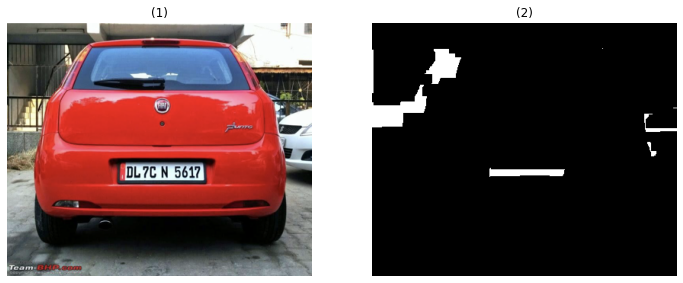

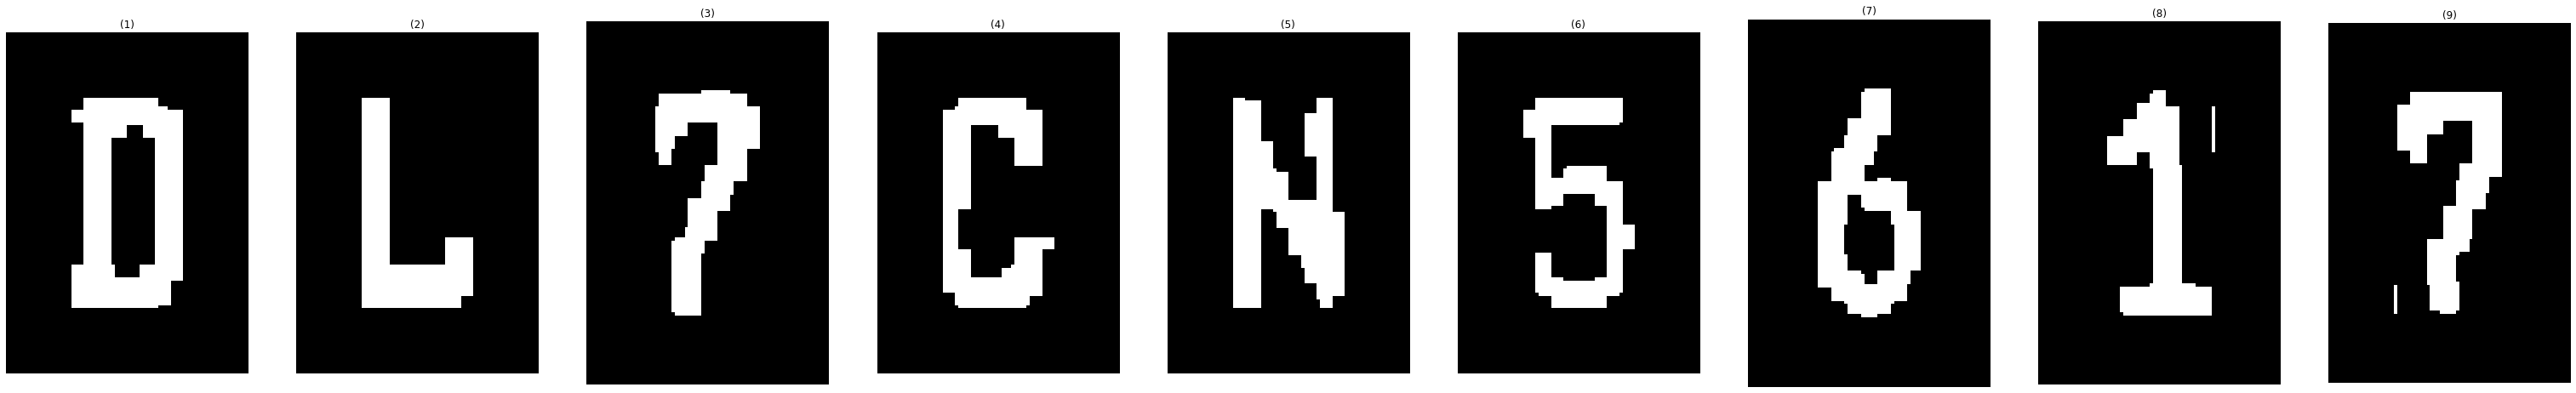

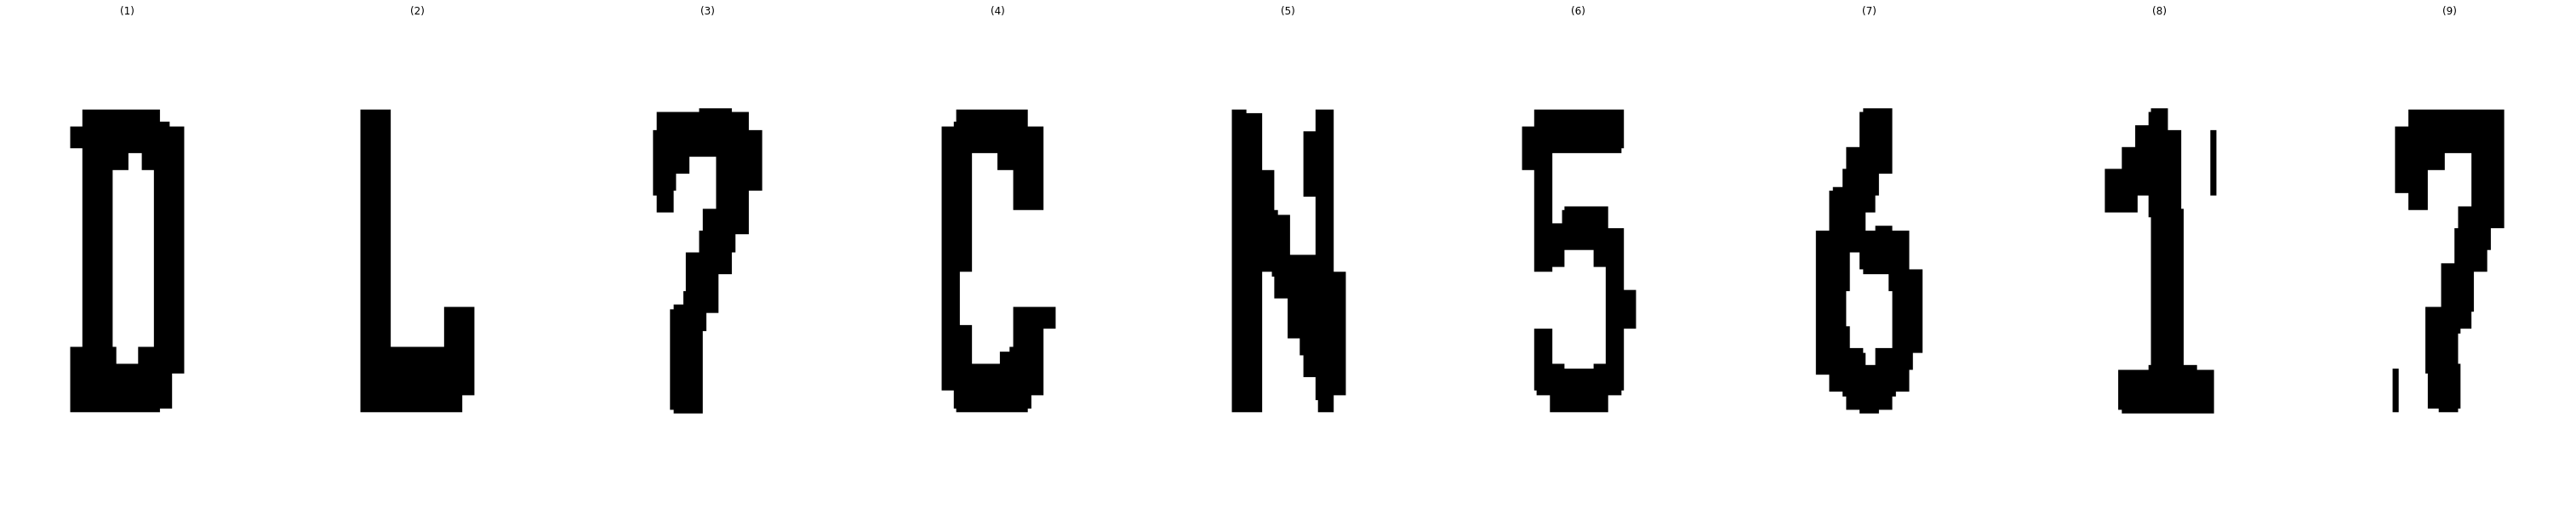

|LfuN86!q


In [21]:
img = fixRange(io.imread("./Images/Cars34.png"))
string, new_chars, chars = "", [], []

processed_img = preprocess(img)
plate = getLicensePlate(processed_img, img)
show_images([img, processed_img])
if len(plate) > 0:
    string, new_chars, chars = getStringFromPlate(plate[0])
if len(string) == 0:
    processed_img = preprocess(img, close_struct_size=35)
    plate = getLicensePlate(processed_img, img, big=True)
    show_images([img, processed_img])
if len(plate) > 0:
    string, new_chars, chars = getStringFromPlate(plate[0])
if len(string) == 0:
    print("Couldn't get any characters")
else:
    show_images(chars)
    show_images(new_chars)
    print(string)
